In [1]:
import matplotlib.pyplot as plt
import torch
import json

In [2]:
base_path = 'reports/FIMImpuation/DummyData/09-05-1233_epoch-117_test/'

predictions = torch.load(base_path + 'predictions.pth')


In [3]:
predictions["imputation_window"]['locations'].shape

torch.Size([25000, 52, 1])

# Visualizations

In [4]:
# get 16 random samples
torch.manual_seed(42)
sample_ids = sorted(torch.randint(0, len(predictions['imputation_window']['target']), (16,)))
sample_ids = [v.item() for v in sample_ids]
print(sample_ids)


[1067, 1924, 8954, 11876, 12113, 12542, 14014, 15026, 16378, 17210, 17572, 18620, 19950, 21414, 22335, 23231]


In [5]:
def plot_sample(line_plot_data: dict, sample_id: int, ax):
    colors = ["red", "teal", "gold", "green", "red", "teal", "gold", "green"]
    batch_size, observed_window_count, _, _ = line_plot_data["observations"]["times"].shape

    imputation_times = line_plot_data["imputation_window"]["locations"][sample_id]
    imputation_target = line_plot_data["imputation_window"]["target"][sample_id]
    imputation_learnt = line_plot_data["imputation_window"]["learnt"][sample_id]

    for i in range(observed_window_count):
        obs_mask = line_plot_data["observations"]["mask"][sample_id, i, ...]
        obs_times = line_plot_data["observations"]["times"][sample_id, i, ...][~obs_mask]
        obs_values = line_plot_data["observations"]["values"][sample_id, i, ...][~obs_mask]

        ax.scatter(
            obs_times, sample_id * 0.5 + obs_values, color=colors[i], marker="x", label=f"observed window {i}"
        )
    ax.plot(
        imputation_times, sample_id * 0.5 + imputation_target, color="black", linestyle="--", label="target"
    )
    ax.plot(imputation_times, sample_id * 0.5 + imputation_learnt, color="blue", label="learnt")
    # axs[0].legend()
    ax.set_title("{}".format(sample_id))
    ax.set_xlabel("Time")

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    
def plot_drift_sample(line_plot_data: dict, sample_id: int, ax):

    # plot drift
    drift = line_plot_data["drift"]["learnt"][sample_id].squeeze(-1)
    certainty = line_plot_data["drift"]["certainty"][sample_id].squeeze(-1)
    target_drift = line_plot_data["drift"]["target"][sample_id].squeeze(-1)
    imputation_times = line_plot_data["imputation_window"]["locations"][sample_id].squeeze(-1)

    ax.plot(imputation_times, drift, color="blue", label="learnt")
    ax.fill_between(
        imputation_times.squeeze(-1),
        drift - certainty,
        drift + certainty,
        alpha=0.3,
        color="blue",
        label="certainty",
    )
    ax.plot(imputation_times, target_drift, color="black", linestyle="--", label="target")
    ax.set_title("{}".format(sample_id))

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


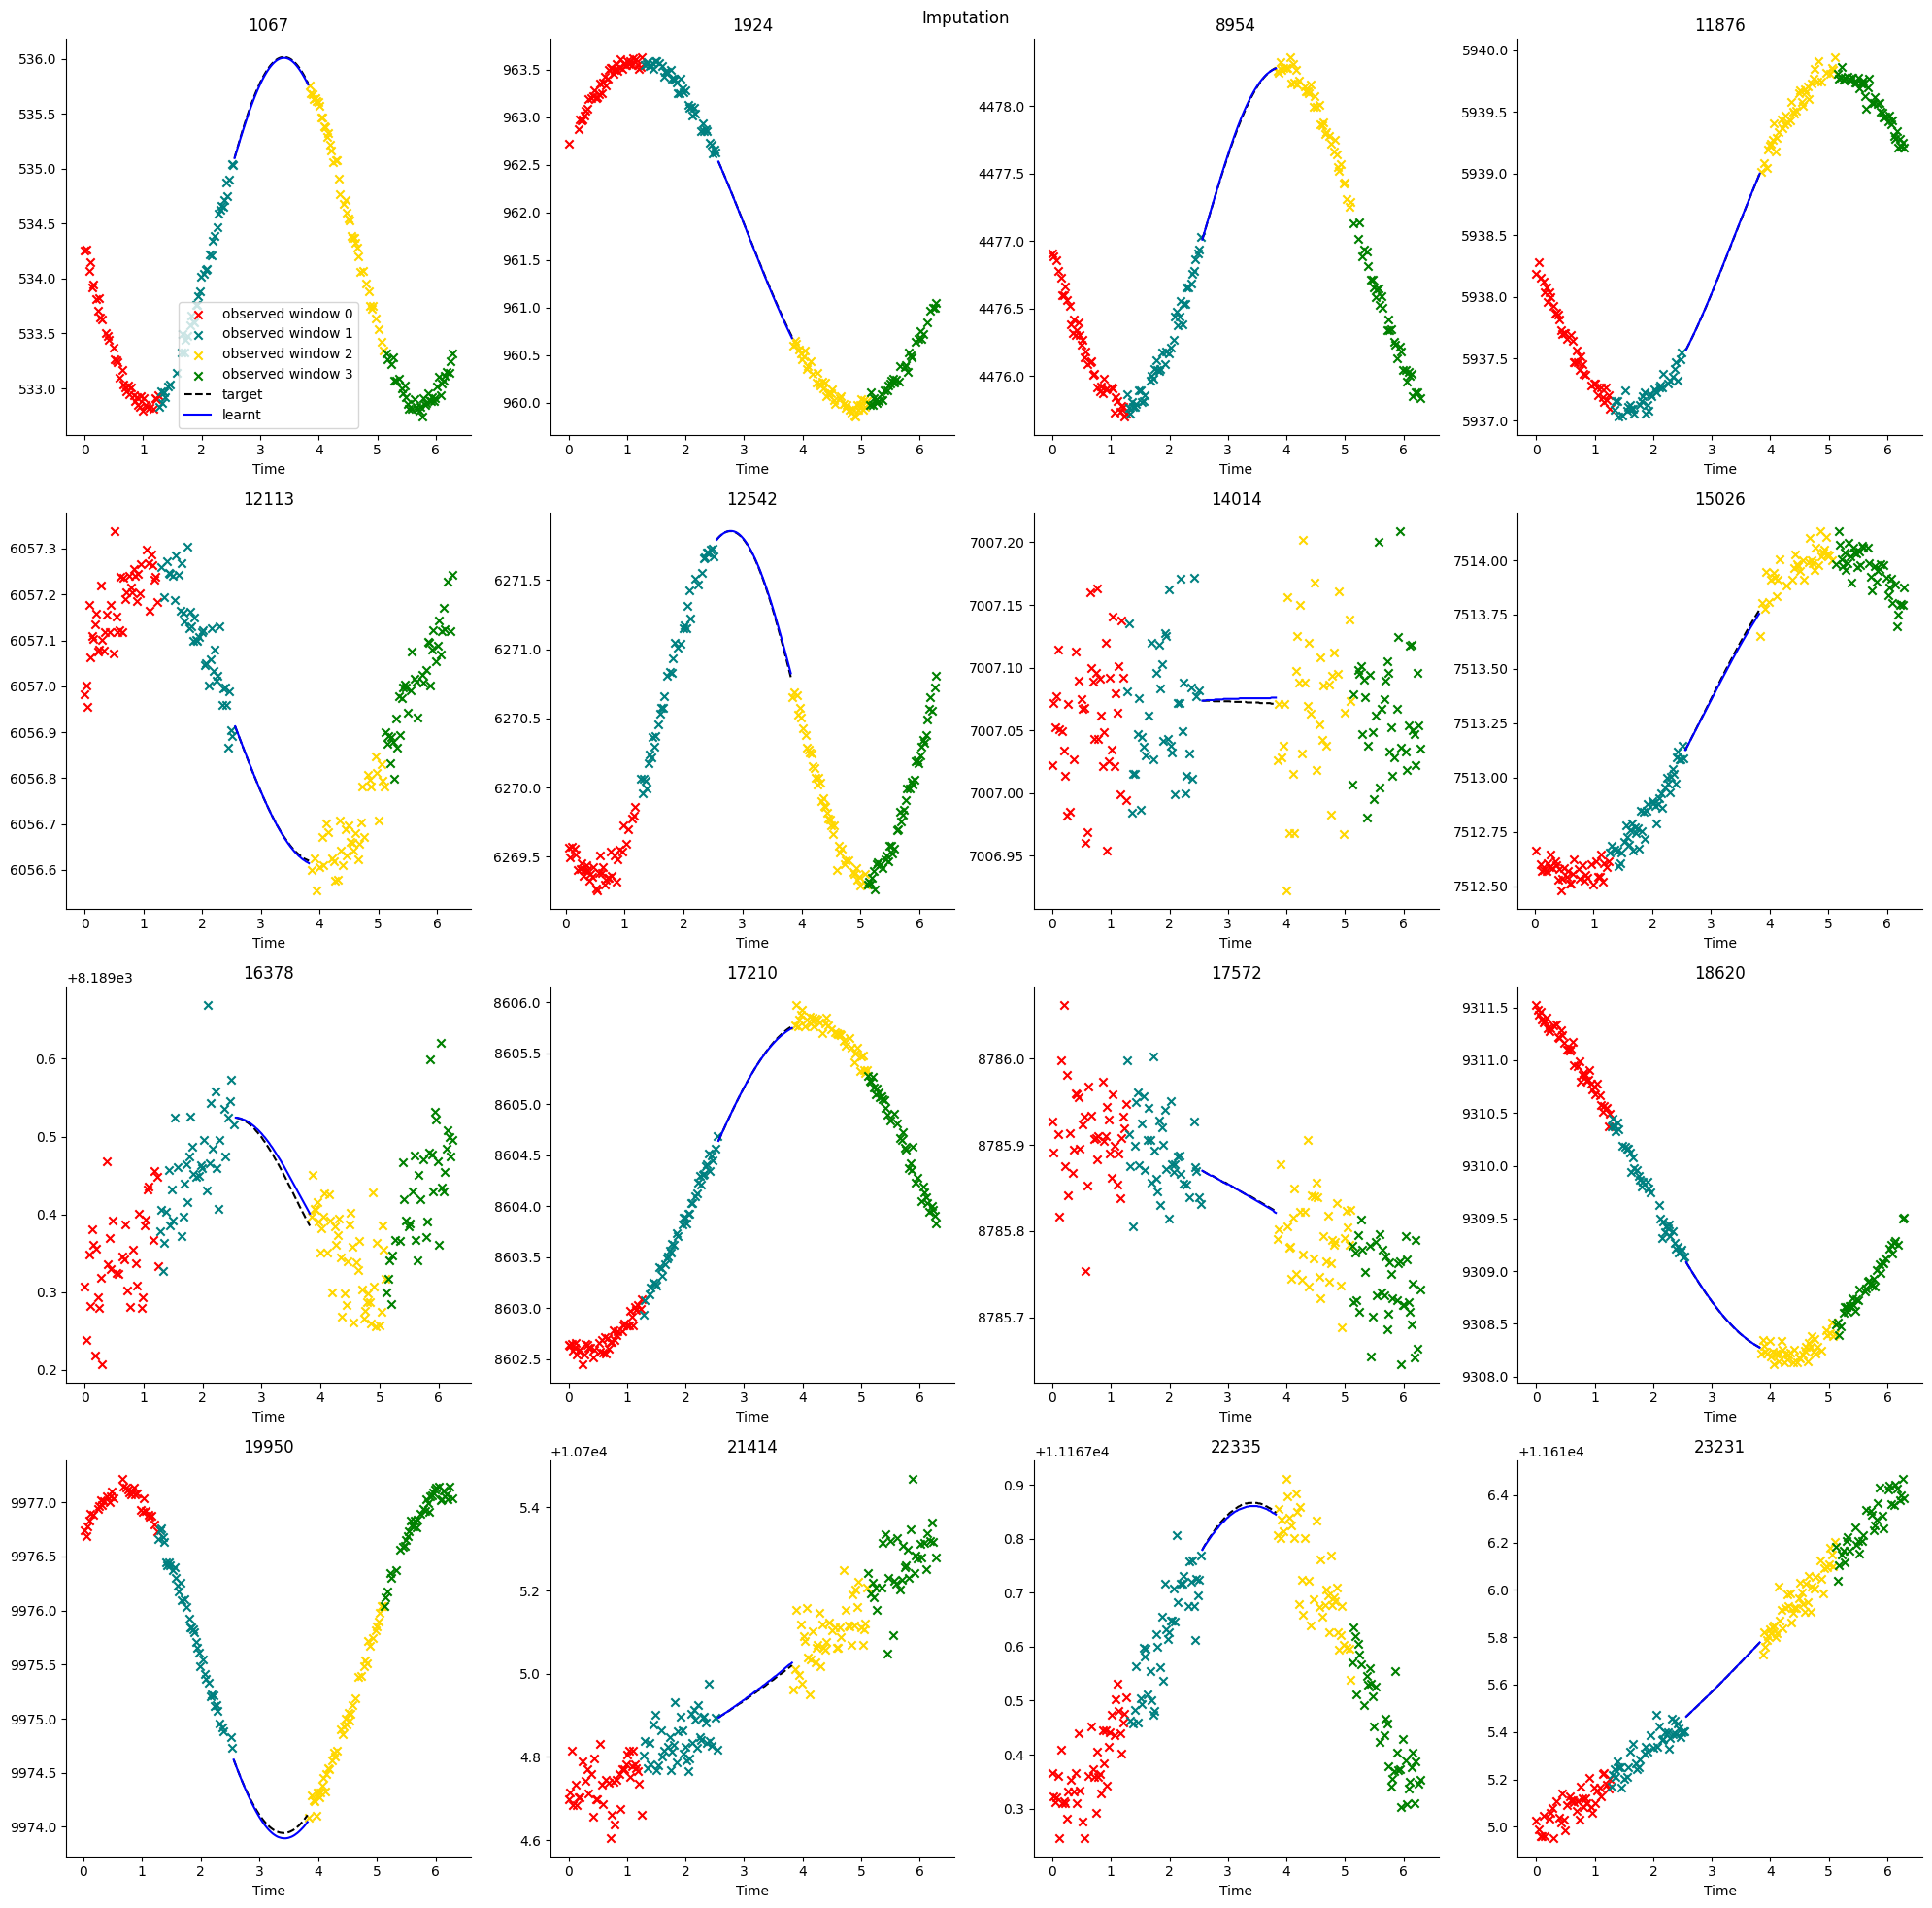

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for ax, sample_id in zip(axs.flatten(), sample_ids):
    plot_sample(predictions, sample_id, ax)
fig.suptitle("Imputation")
axs[0,0].legend()
plt.tight_layout()
plt.savefig(base_path + "imputation.png")
plt.show()

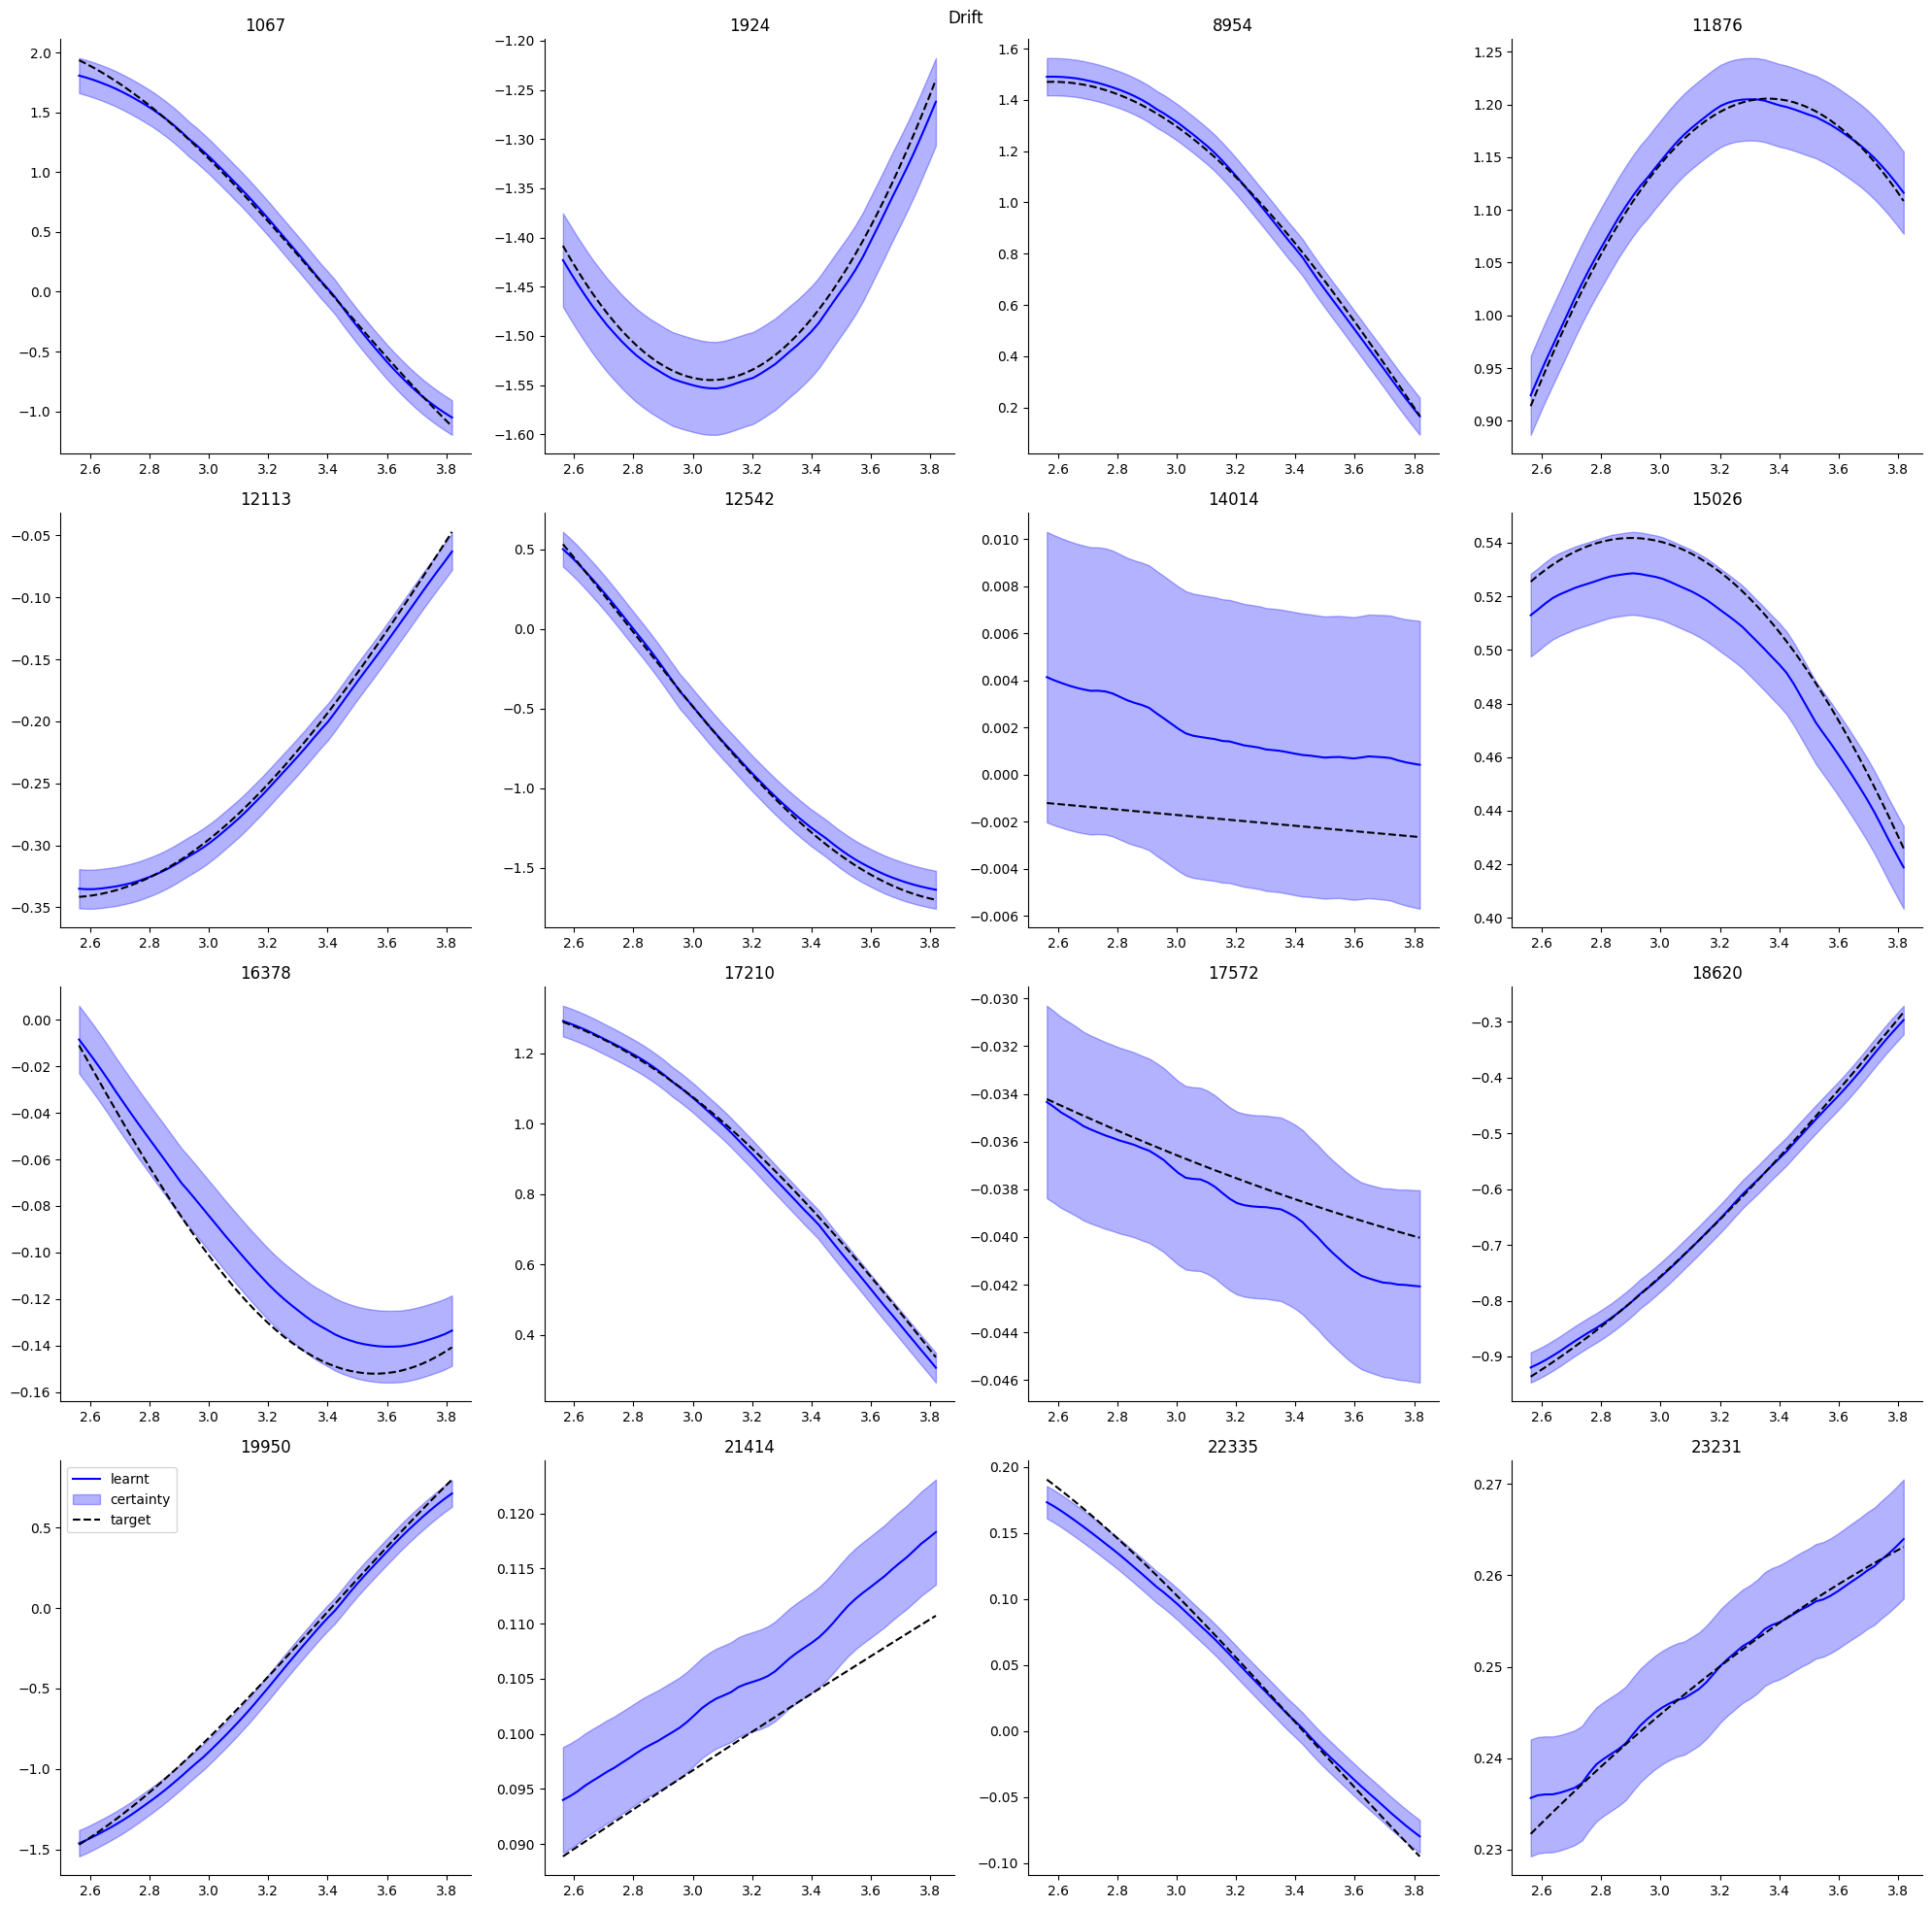

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for ax, sample_id in zip(axs.flatten(), sample_ids):
    plot_drift_sample(predictions, sample_id, ax)

fig.suptitle("Drift")
fig.tight_layout()
axs[-1][0].legend()
plt.savefig(base_path + "drift.png")
plt.show()

# Metrics

In [8]:

metrics: dict = json.load(open(base_path + 'metrics.json', "r"))
print(json.dumps(metrics, indent=2))

{
  "r2_score_mean": -7.564112663269043,
  "r2_score_std": 551.4554443359375,
  "r2_score_above0.9": 0.9223200082778931,
  "mae_mean": 0.009229586459696293,
  "mae_std": 0.01637820526957512,
  "mse_mean": 0.00043070901301689446,
  "mse_std": 0.002469258615747094,
  "rmse_mean": 0.010494711808860302,
  "rmse_std": 0.017904825508594513
}
